### Regularized Regression (Ridge)

In [92]:
library(ggplot2)
library(dplyr)
library(glmnet)

In [93]:
df <- mtcars
head(df,6)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


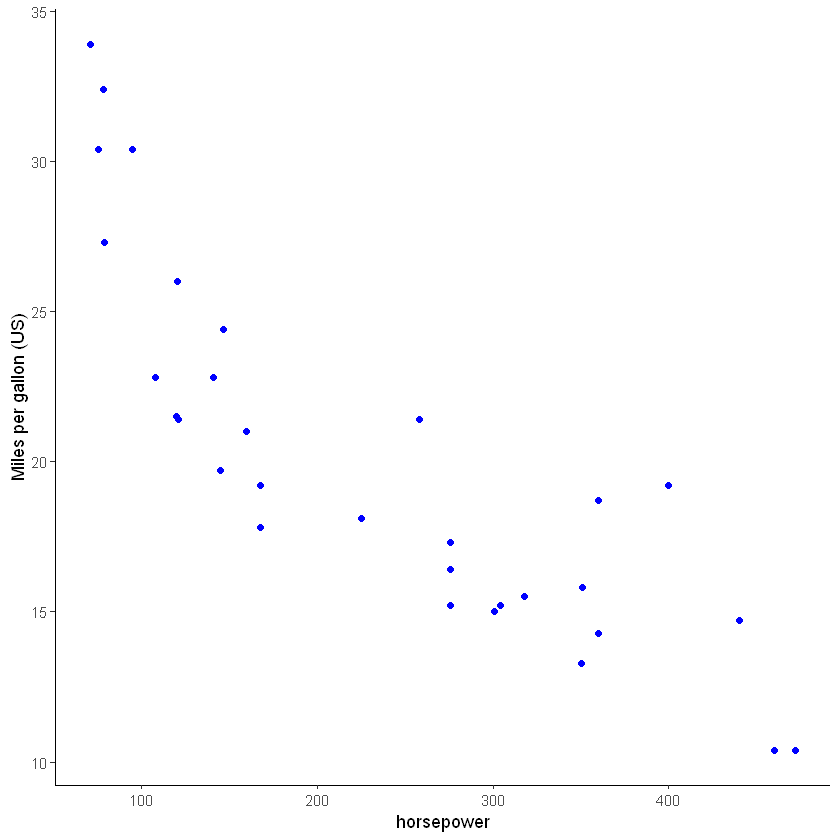

In [94]:
plot1 <- df %>%
  ggplot(aes(x=disp,y=mpg)) +
  geom_point(col='blue') +
  theme_classic() + 
  xlab('horsepower') +
  ylab('Miles per gallon (US)') 
plot1 

Turns out that there might be a polynomial relationship between mpg & displacement.

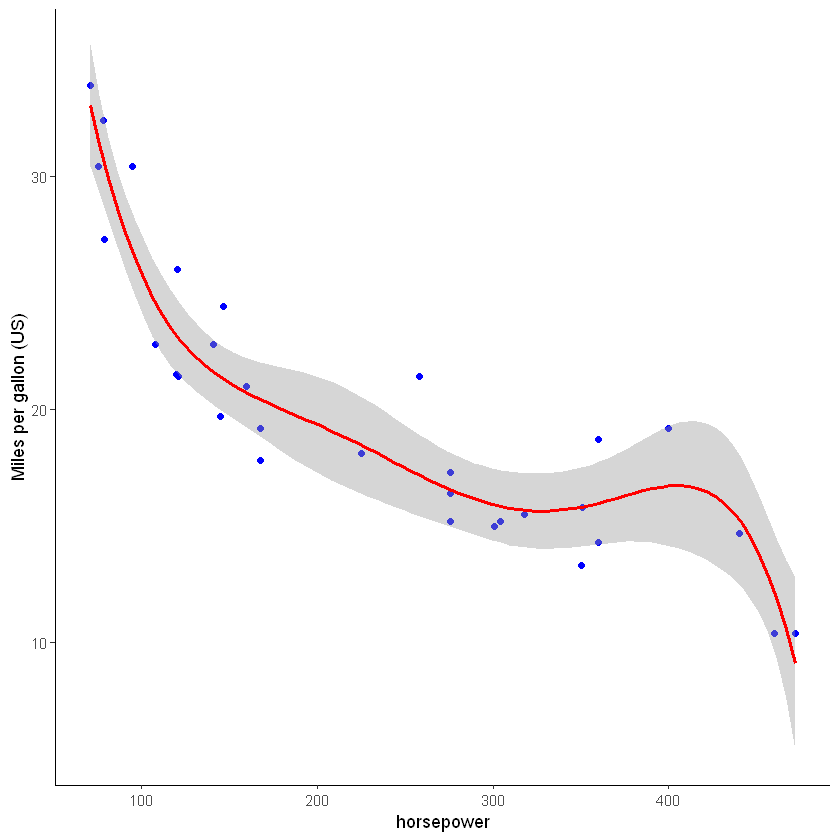

In [95]:
# Suppose we fit a higher degree of polynomial in our model
plot1 + stat_smooth(method = 'lm', se = TRUE, formula = y ~ poly(x,5), col = 'red')


In [96]:
# Fitting a poly regression model (deg = 5)
mod.reg <- lm(formula = mpg ~ poly(disp,degree = 5), data = df)
summary(mod.reg)


Call:
lm(formula = mpg ~ poly(disp, degree = 5), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2416 -1.6871 -0.2752  1.2114  4.1993 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              20.09062    0.37689  53.306  < 2e-16 ***
poly(disp, degree = 5)1 -28.44097    2.13203 -13.340 3.88e-13 ***
poly(disp, degree = 5)2   9.15235    2.13203   4.293 0.000217 ***
poly(disp, degree = 5)3  -9.74460    2.13203  -4.571 0.000104 ***
poly(disp, degree = 5)4  -0.01148    2.13203  -0.005 0.995745    
poly(disp, degree = 5)5  -4.50020    2.13203  -2.111 0.044566 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.132 on 26 degrees of freedom
Multiple R-squared:  0.895,	Adjusted R-squared:  0.8749 
F-statistic: 44.35 on 5 and 26 DF,  p-value: 6.504e-12


Fitting a polynomial regression with a degree n = 5, gave us better coefficients that are statistically significant based upon p-value and r-squared.


In [97]:
# Determining RMSE (model perf.) using LOOCV

SE <- numeric(nrow(df))

for(i in 1:nrow(df)){
  train <- df[-i,]
  test <- df[i,]
  
  poly.mod <- lm(formula = mpg ~ poly(disp,degree = 5) ,train)
  poly.pred <- predict(poly.mod,test)
  
  SE[i] <- (test$mpg - poly.pred )^2
}

mse.loocv <- mean(SE)
cat('MSE:',mse.loocv, '\nRMSE:',sqrt(mse.loocv))

MSE: 5.930802 
RMSE: 2.435324

#### Ridge Regression as shrinkage method

Initially, we built a model that is more complex than the simple linear regression model. As model complexity increases, it also increases the variance. Shrinkage (regularization) forces all estimates to shrink towards zero relative to estimates.

How does this work?

In a linear model, we use Residual Sum of Squares (RSS) as measure of the variance in the error term/residuals. What shrinkage does is by having a penalty term in the RSS, it can help control the magnitude of the coefficients.

$$RSS = \sum_{i=1}^{n} (y_i - \hat{y_i})^2 = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p} \beta_jX_j)^2$$

*Adding the penalty term,* $$RSS = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p} \beta_jX_j)^2 + \lambda \sum_{j=1}^{p} \beta_j^2$$



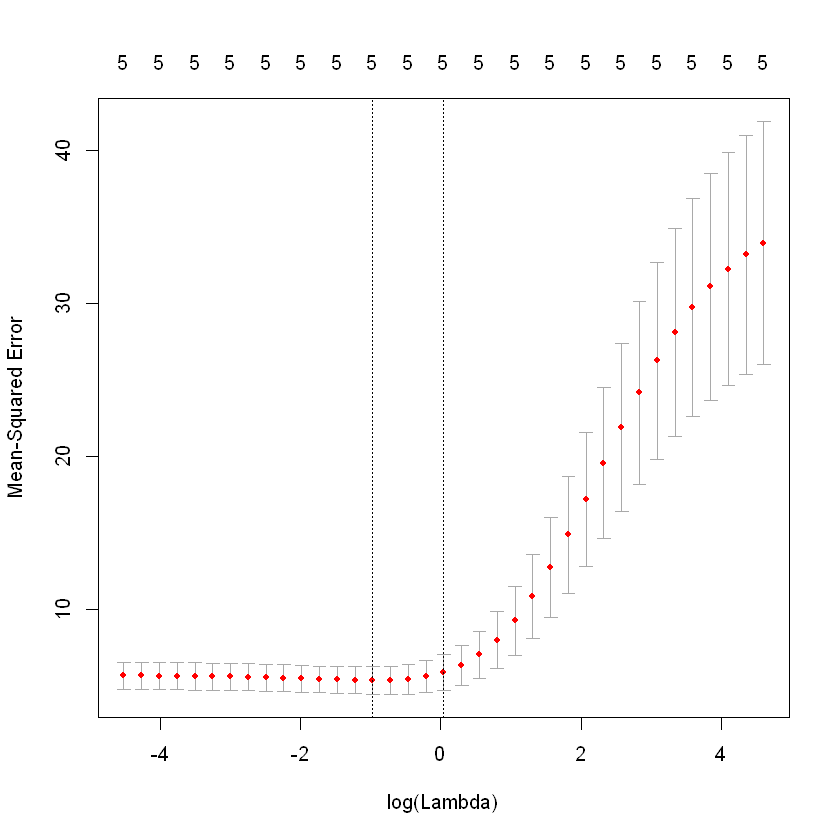

In [98]:
# How do we determine the lambda (tuning parameter)? 

# Arrange data into matrix type
poly_disp <- poly(df$disp,5)
y <- df[['mpg']]

# Determining best lambda
lambda_seq <- 10^seq(2,-2, by =-0.11)
cvridge.mod <- cv.glmnet(poly_disp, y, alpha = 0 , lambda=lambda_seq)
plot(cvridge.mod)

In [99]:
# Applying best lambda
best_lambda <- cvridge.mod$lambda.min
ridge.mod <- glmnet(poly_disp, y, alpha = 0 , lambda=best_lambda)
ridge.mod


Call:  glmnet(x = poly_disp, y = y, alpha = 0, lambda = best_lambda) 

     Df   %Dev Lambda
[1,]  5 0.8918 0.3802

In [100]:
# Using LOOCV
SEridge <- numeric(nrow(df))
matrix.df <- cbind(y,poly_disp)

for(i in 1:nrow(matrix.df)){
  train <- matrix.df[-i,]
  test <- matrix.df[i, ]

  ridge.mod <- glmnet(train[,-1], train[,1], alpha = 0 , lambda=best_lambda)
  ridge.pred <- predict(ridge.mod, newx = as.matrix(t(test[2:6])))

  SEridge[i] <- (ridge.pred - test[1])^2

}
mse.loocvRidge <- mean(SEridge)
cat('MSE:',mse.loocvRidge , '\nRMSE:',sqrt(mse.loocvRidge))

MSE: 5.618742 
RMSE: 2.370389

Comparing the results earlier from the initial poly model $RMSE = 2.44$ , we got a better $RSME = 2.37$ using the shrinkage method. Therefore, the shrinkage help us achieve a better performance on RMSE.
